# Evaluate MPNN Performance
Review the models which have been trained and pick one for our application.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Models
They are all located in a directory with a `test_summary.json` file

In [2]:
model_dirs = list(map(os.path.dirname, glob(os.path.join('networks', '**', 'test_summary.json'))))
print(f'Found {len(model_dirs)} model directories')

Found 18 model directories


In [3]:
def get_summary(path):
    """Get the summary of a run"""
    
    output = {'path': path}
    
    # Load the config
    with open(os.path.join(path, 'config.json')) as fp:
        output.update(json.load(fp))
        
    # Load in the run summary
    with open(os.path.join(path, 'test_summary.json')) as fp:
        output.update(json.load(fp))
    return output

In [4]:
models = pd.DataFrame(get_summary(p) for p in model_dirs).sort_values('mae', ascending=True)
models.head(5)

,path,atom_features,num_messages,output_layers,batch_size,num_epochs,system,lr_start,reduce_op,atomwise,runtime,r2_score,spearmanr,kendall_tau,mae,rmse
1,networks/gpu_b16_n256_Rsum_cbd46e,64,6,"[512, 256, 128]",16,256,gpu,0.001,sum,False,367.356733,0.904274,0.957978,0.830779,0.182403,0.266382
2,networks/gpu_b16_n256_Rsum_9eb813,64,4,"[512, 256, 128]",16,256,gpu,0.001,sum,False,300.565175,0.908244,0.963184,0.839491,0.190486,0.267309
10,networks/gpu_b16_n256_Rsum_e12c99,64,8,"[512, 256, 128]",16,256,gpu,0.001,sum,False,634.556888,0.852825,0.937831,0.809784,0.205228,0.330503
14,networks/gpu_b16_n256_Rsum_e62d30,16,8,"[512, 256, 128]",16,256,gpu,0.001,sum,False,648.147453,0.842795,0.932949,0.805643,0.206372,0.344457
11,networks/gpu_b16_n256_Rmin_b97c6b,32,8,"[512, 256, 128]",16,256,gpu,0.001,min,False,429.959445,0.842717,0.940514,0.806265,0.208273,0.338672


## Validate the Model
Visualize the results on the hold-out set of 10% of our data

In [5]:
best_model = models.iloc[0]

In [6]:
best_model

path             networks/gpu_b16_n256_Rsum_cbd46e
atom_features                                   64
num_messages                                     6
output_layers                      [512, 256, 128]
batch_size                                      16
num_epochs                                     256
system                                         gpu
lr_start                                     0.001
reduce_op                                      sum
atomwise                                     False
runtime                                 367.356733
r2_score                                  0.904274
spearmanr                                 0.957978
kendall_tau                               0.830779
mae                                       0.182403
rmse                                      0.266382
Name: 1, dtype: object

Print the predicted-vs-acutal

In [7]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))

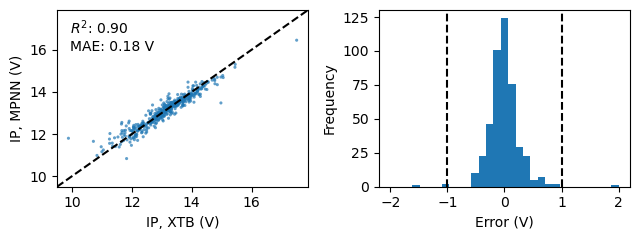

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true'])

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=5, alpha=0.7, edgecolor='none')
ax.text(0.05, 0.95, f'$R^2$:{best_model["r2_score"]: .2f}\nMAE:{errors.abs().mean(): .2f} V', 
       transform=ax.transAxes, va='top', ha='left')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('IP, XTB (V)')
ax.set_ylabel('IP, MPNN (V)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-2, 2, 32))
ax.text(1, 0.95, f'', 
       transform=ax.transAxes, va='top', ha='right')

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (V)')
ax.set_ylabel('Frequency')
fig.tight_layout()

Print the training log

In [9]:
train_log = pd.read_csv(os.path.join(best_model['path'], 'train_log.csv'))

Text(0, 0.5, 'Loss')

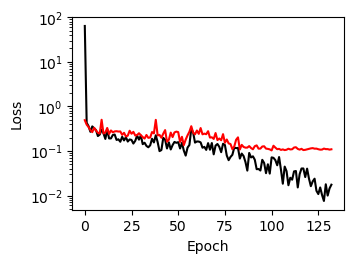

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(train_log.index, train_log['loss'], 'k-', label='Train')
ax.semilogy(train_log.index, train_log['val_loss'], 'r-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')